In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')

In [2]:
sentiment = pd.read_csv("fear_greed_index.csv")

In [3]:
trader = pd.read_csv("historical_data.csv")

In [4]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [5]:
trader.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [6]:
print("Sentiment Shape:", sentiment.shape)

Sentiment Shape: (2644, 4)


In [7]:
print("\nSentiment Columns:\n", sentiment.columns)


Sentiment Columns:
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [8]:
print("Trader Shape:", trader.shape)

Trader Shape: (211224, 16)


In [9]:
# Remove duplicates
sentiment.drop_duplicates(inplace=True)

In [10]:
trader.drop_duplicates(inplace=True)

In [11]:
# Missing values
print(sentiment.isnull().sum())

timestamp         0
value             0
classification    0
date              0
dtype: int64


In [12]:
print(trader.isnull().sum())

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [13]:
trader['Timestamp IST'] = pd.to_datetime(
    trader['Timestamp IST'],
    errors='coerce',
    dayfirst=True
)

In [14]:
print("Invalid timestamps:", trader['Timestamp IST'].isna().sum())

Invalid timestamps: 0


In [15]:
trader = trader.dropna(subset=['Timestamp IST'])

In [16]:
trader['date'] = trader['Timestamp IST'].dt.normalize()

In [17]:
sentiment['date'] = pd.to_datetime(
    sentiment['date'],
    errors='coerce',
    dayfirst=True
).dt.normalize()

In [18]:
merged = trader.merge(sentiment, on='date', how='left')

print("Before alignment:", merged.shape)

Before alignment: (211224, 20)


In [19]:
print(merged['classification'].value_counts(dropna=False))

classification
NaN              175360
Fear              13869
Greed             11292
Extreme Greed      5621
Neutral            2756
Extreme Fear       2326
Name: count, dtype: int64


In [20]:
merged = merged.dropna(subset=['classification'])

print("\nAfter alignment:", merged.shape)


After alignment: (35864, 20)


In [21]:
print(merged['classification'].value_counts())

classification
Fear             13869
Greed            11292
Extreme Greed     5621
Neutral           2756
Extreme Fear      2326
Name: count, dtype: int64


In [22]:
daily_pnl = merged.groupby(['Account','date'])['Closed PnL'].sum().reset_index()
daily_pnl.rename(columns={'Closed PnL':'daily_pnl'}, inplace=True)

daily_pnl.head()

,Account,date,daily_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-12-06,-175611.000056
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,76710.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-03,101011.685664
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-04,375620.270243


In [23]:
merged['win'] = merged['Closed PnL'] > 0

win_rate = merged.groupby('Account')['win'].mean().reset_index()
win_rate.rename(columns={'win':'win_rate'}, inplace=True)

win_rate.head()

,Account,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.403057
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.400168
2,0x271b280974205ca63b716753467d5a371de622ab,0.750000
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.478261
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.518519


In [24]:
avg_trade_size = merged.groupby('Account')['Size USD'].mean().reset_index()
avg_trade_size.rename(columns={'Size USD':'avg_trade_size'}, inplace=True)

avg_trade_size.head()

,Account,avg_trade_size
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16277.368089
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2019.281124
2,0x271b280974205ca63b716753467d5a371de622ab,39530.987500
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,372.626975
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,2914.655714


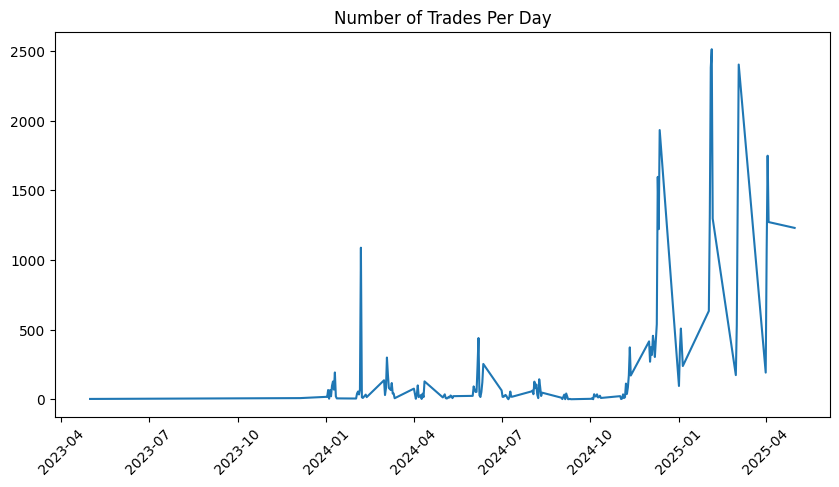

In [25]:
trades_per_day = merged.groupby('date')['Account'].count().reset_index()
trades_per_day.rename(columns={'Account':'num_trades'}, inplace=True)

plt.figure(figsize=(10,5))
plt.plot(trades_per_day['date'], trades_per_day['num_trades'])
plt.title("Number of Trades Per Day")
plt.xticks(rotation=45)
plt.show()

In [26]:
long_short = merged.groupby(['date','Side'])['Account'].count().unstack().fillna(0)

In [27]:
long_short = merged.groupby(['date','Side'])['Account'].count().unstack(fill_value=0)

In [28]:
long_short['long_short_ratio'] = long_short.get('BUY',0) / (long_short.get('SELL',0) + 1)

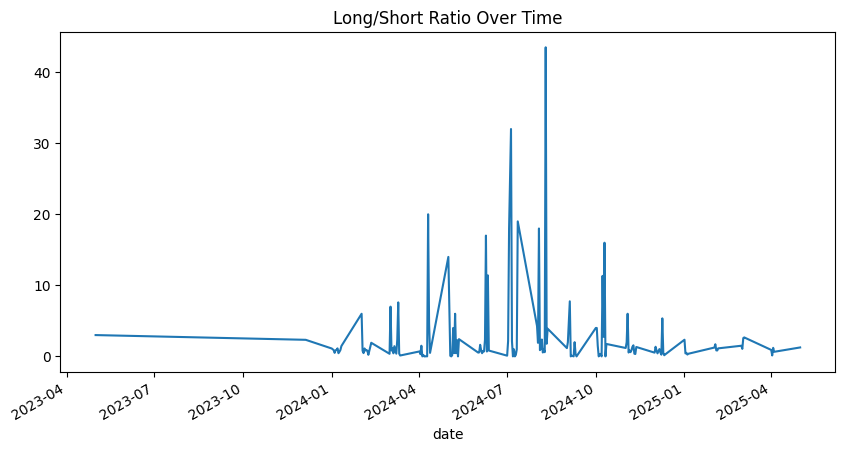

In [29]:
long_short['long_short_ratio'].plot(figsize=(10,5), title="Long/Short Ratio Over Time")
plt.show()

classification
Extreme Fear       1.891632
Extreme Greed    205.816345
Fear             128.287950
Greed             53.988003
Neutral           27.088803
Name: Closed PnL, dtype: float64


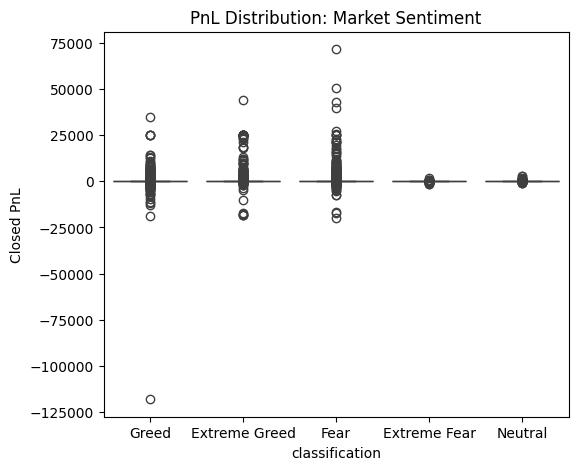

In [30]:
performance = merged.groupby('classification')['Closed PnL'].mean()
print(performance)

plt.figure(figsize=(6,5))
sns.boxplot(x='classification', y='Closed PnL', data=merged)
plt.title("PnL Distribution: Market Sentiment")
plt.show()

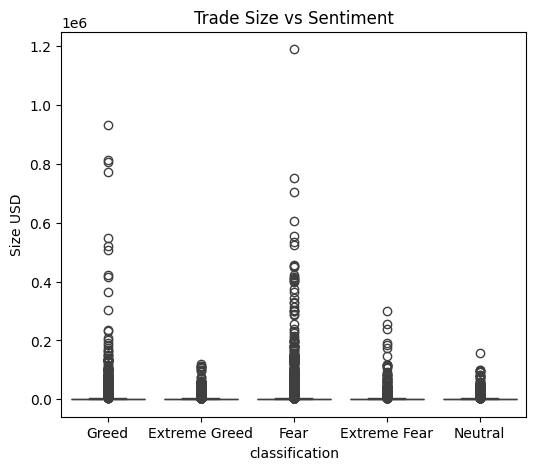

In [31]:
plt.figure(figsize=(6,5))
sns.boxplot(x='classification', y='Size USD', data=merged)
plt.title("Trade Size vs Sentiment")
plt.show()

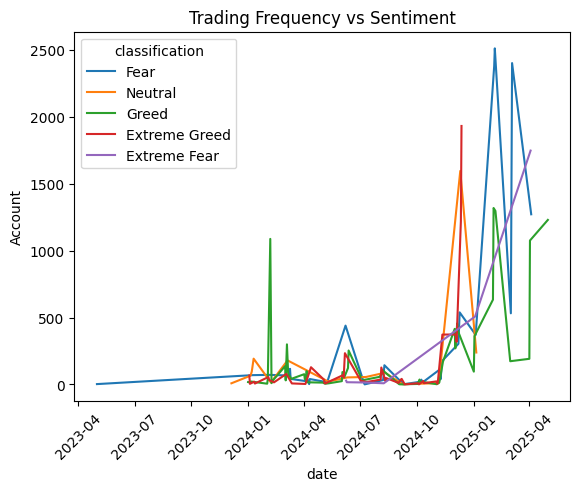

In [32]:
freq_sentiment = merged.groupby(['date','classification'])['Account'].count().reset_index()

sns.lineplot(data=freq_sentiment, x='date', y='Account', hue='classification')
plt.xticks(rotation=45)
plt.title("Trading Frequency vs Sentiment")
plt.show()

In [33]:
q75 = merged['Size USD'].quantile(0.75)
q25 = merged['Size USD'].quantile(0.25)

merged['risk_segment'] = np.select(
    [
        merged['Size USD'] >= q75,
        merged['Size USD'] <= q25
    ],
    ['High Risk','Low Risk'],
    default='Medium Risk'
)

In [34]:
trade_count = merged.groupby('Account')['Account'].count()
median_trades = trade_count.median()

merged['frequency_segment'] = merged['Account'].map(
    lambda x: 'Frequent' if trade_count[x] > median_trades else 'Infrequent'
)

In [35]:
win_rate_map = merged.groupby('Account')['win'].mean()

merged['winner_segment'] = merged['Account'].map(
    lambda x: 'Consistent Winner' if win_rate_map.get(x,0) >= 0.6 else 'Others'
)

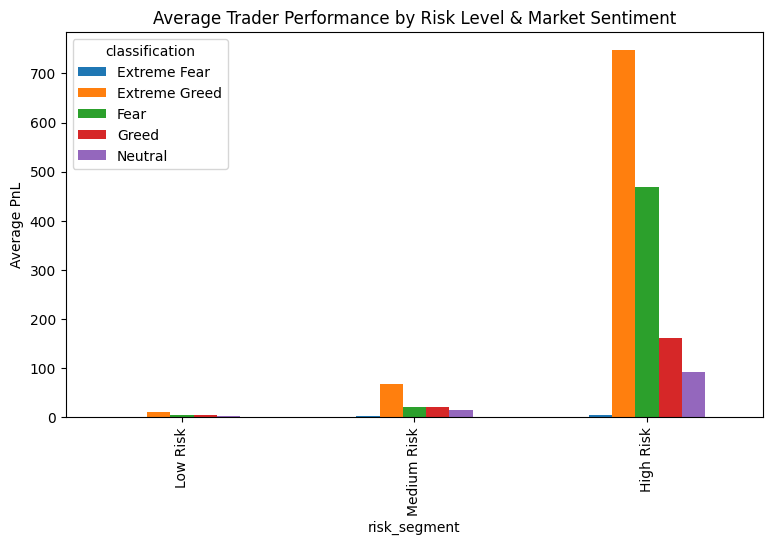

In [37]:
segment_perf = merged.groupby(['risk_segment','classification'])['Closed PnL'].mean().unstack()

segment_perf = segment_perf.loc[['Low Risk','Medium Risk','High Risk']]
segment_perf.plot(kind='bar', figsize=(9,5))
plt.ylabel("Average PnL")
plt.title("Average Trader Performance by Risk Level & Market Sentiment")
plt.show() 